# Focus Extracting 5 Parameters [Dopant, Doping Method, Solvent, Film Preparation Method, References]
=====================================================================================================
1. Dopant
A chemical you add to the polymer to change its electrical behavior, usually to make it conduct better.

2. Doping method
How the dopant is added to the material, for example, mixing in solution, soaking the film, vapor exposure, or electrochemical doping.

3. Solvent
The liquid used to dissolve or disperse the polymer or dopant so you can make a uniform solution, like water, ethanol, chloroform, or DMSO.

4. Film preparation method
How the thin film is actually made on a surface, like spin coating, drop casting, blade coating, printing, or vacuum deposition.

5. References
DOI, page number, etc.

# The Big Picture: 
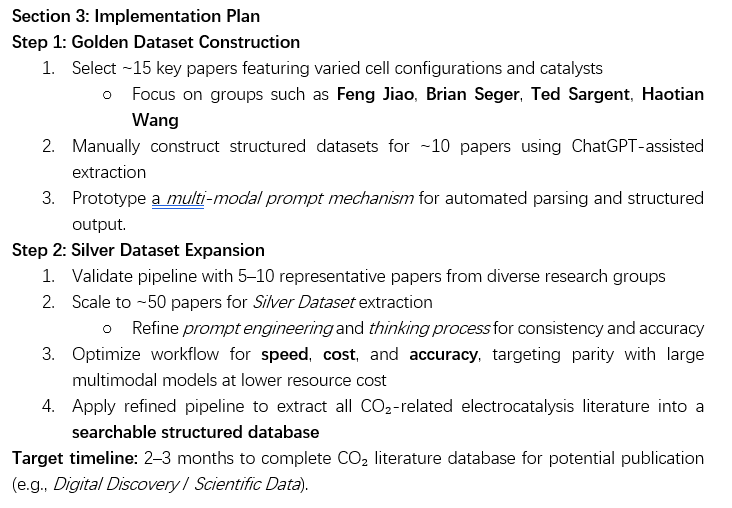

# Each parameter has a function & Generic Helpers

In [8]:
# pip install pymupdf
# If you already have the full text, you can skip PDF parsing and just call extract_all_5(page_text)

import re
import json
from typing import Dict, List, Optional

# -------------------------
# Generic helpers
# -------------------------
def _normalize(text: str) -> str:
    text = text.replace("\u00ad", "")  # soft hyphen
    text = re.sub(r"[ \t]+", " ", text)
    text = re.sub(r"\n{3,}", "\n\n", text)
    return text.strip()

def _find_all(pattern: str, text: str, flags=re.IGNORECASE | re.MULTILINE) -> List[str]:
    return [m.group(0).strip() for m in re.finditer(pattern, text, flags)]

def _find_first_group(pattern: str, text: str, flags=re.IGNORECASE | re.MULTILINE) -> Optional[str]:
    m = re.search(pattern, text, flags)
    return m.group(1).strip() if m else None

# -------------------------
# 1) Dopant
# -------------------------
def extract_dopant(text: str) -> List[str]:
    text = _normalize(text)
    chem = r"[A-Za-z0-9µμ·\-\+\(\)\[\]\.]{2,}"
    patterns = [
        rf"\bdopant\s*[:\-]\s*({chem}(?:\s+{chem}){{0,4}})",
        rf"\bdoped\s+with\s+({chem}(?:\s+{chem}){{0,4}})",
        rf"\bdoping\s+with\s+({chem}(?:\s+{chem}){{0,4}})",
    ]
    hits = []
    for p in patterns:
        hits += [m.group(1).strip() for m in re.finditer(p, text, re.IGNORECASE | re.MULTILINE)]
    return list(dict.fromkeys(hits))

# -------------------------
# 2) Doping Method
# -------------------------
def extract_doping_method(text: str) -> List[str]:
    text = _normalize(text)
    patterns = [
        r"\b(vapor\s+dop(?:ing|ed)[^.\n]{0,120})",
        r"\b(electrochemical\s+dop(?:ing|ed)[^.\n]{0,120})",
        r"\b(soak(?:ing|ed)\s+(?:the\s+)?film[^.\n]{0,120})",
        r"\b(immersion\s+(?:doping|process)[^.\n]{0,120})",
        r"\b(solution\s+dop(?:ing|ed)[^.\n]{0,120})",
        r"\b(in\s+situ\s+dop(?:ing|ed)[^.\n]{0,120})",
        r"\b(post[-\s]?treat(?:ment|ed)[^.\n]{0,120})",
    ]
    hits = []
    for p in patterns:
        hits += [m.group(1).strip() for m in re.finditer(p, text, re.IGNORECASE | re.MULTILINE)]
    return list(dict.fromkeys(hits))

# -------------------------
# 3) Solvent
# -------------------------
def extract_solvent(text: str) -> List[str]:
    text = _normalize(text)
    solvent_token = r"[A-Za-z][A-Za-z0-9\-\/]{1,30}"
    patterns = [
        rf"\bsolvent\s*[:\-]\s*({solvent_token}(?:\s+{solvent_token}){{0,2}})",
        rf"\bdissolv(?:ed|ing)\s+in\s+({solvent_token}(?:\s+{solvent_token}){{0,2}})",
        rf"\bdispers(?:ed|ing)\s+in\s+({solvent_token}(?:\s+{solvent_token}){{0,2}})",
        rf"\bin\s+({solvent_token})\s+(?:solution|at\s+\d+|was|were|and)\b",
    ]
    hits = []
    for p in patterns:
        hits += [m.group(1).strip() for m in re.finditer(p, text, re.IGNORECASE | re.MULTILINE)]
    return list(dict.fromkeys(hits))

# -------------------------
# 4) Film Preparation Method
# -------------------------
def extract_film_prep_method(text: str) -> List[str]:
    text = _normalize(text)
    patterns = [
        r"\b(spin\s*coated[^.\n]{0,120})",
        r"\b(drop\s*cast(?:ed|ing)?[^.\n]{0,120})",
        r"\b(blade\s*coat(?:ed|ing)?[^.\n]{0,120})",
        r"\b(spray\s*coat(?:ed|ing)?[^.\n]{0,120})",
        r"\b(inkjet\s*print(?:ed|ing)?[^.\n]{0,120})",
        r"\b(screen\s*print(?:ed|ing)?[^.\n]{0,120})",
        r"\b(doctor\s*blade[^.\n]{0,120})",
        r"\b(vacuum\s+deposition[^.\n]{0,120})",
        r"\b(thermal\s+evaporation[^.\n]{0,120})",
    ]
    hits = []
    for p in patterns:
        hits += [m.group(1).strip() for m in re.finditer(p, text, re.IGNORECASE | re.MULTILINE)]
    return list(dict.fromkeys(hits))

# -------------------------
# 5) References
# -------------------------
def extract_references(text: str) -> Dict[str, List[str]]:
    text = _normalize(text)
    doi_pat = r"\b10\.\d{4,9}/[-._;()/:A-Z0-9]+\b"
    bracket_cite = r"\[\s?\d{1,4}\s?\]"
    author_year = r"\([A-Z][A-Za-z\-]+(?:\s+et\s+al\.)?,\s*\d{4}[a-z]?\)"
    page_pat = r"\b(?:p\.|pp\.|page|pages)\s*\d+(?:\s*[-–]\s*\d+)?\b"

    return {
        "doi": _find_all(doi_pat, text, flags=re.IGNORECASE | re.MULTILINE),
        "bracket_citations": _find_all(bracket_cite, text),
        "author_year_citations": _find_all(author_year, text),
        "page_mentions": _find_all(page_pat, text),
    }

def extract_all_5(text: str) -> Dict[str, object]:
    return {
        "dopant": extract_dopant(text),
        "doping_method": extract_doping_method(text),
        "solvent": extract_solvent(text),
        "film_preparation_method": extract_film_prep_method(text),
        "references": extract_references(text),
    }

# Main 

In [17]:
import os

# go forward into a subfolder
os.chdir("notebooks")

# optional: show current working directory
print(os.getcwd())


C:\Users\kasif\Documents\Qatar-Environment-and-Energy-Research-Institute-Internship-Work-\Extraction_System\notebooks


In [19]:
# -------------------------
# PDF page-by-page extraction
# -------------------------
def extract_from_pdf(pdf_path: str) -> Dict[str, object]:
    """
    Goes through each page:
    1) Extracts page text
    2) Applies the 5 extractors
    3) Returns per-page results + combined results across all pages
    """
    import fitz  # pymupdf

    doc = fitz.open(pdf_path)

    per_page = []
    combined = {
        "dopant": [],
        "doping_method": [],
        "solvent": [],
        "film_preparation_method": [],
        "references": {
            "doi": [],
            "bracket_citations": [],
            "author_year_citations": [],
            "page_mentions": [],
        },
    }

    for i in range(len(doc)):
        page = doc.load_page(i)
        page_text = page.get_text("text") or ""
        page_text = _normalize(page_text)

        page_fields = extract_all_5(page_text)

        per_page.append({
            "page": i + 1,
            "page_text": page_text,        # full extracted text of that page
            "extracted": page_fields       # extracted 5-parameter info from that page
        })

        # merge into combined (unique later)
        combined["dopant"] += page_fields["dopant"]
        combined["doping_method"] += page_fields["doping_method"]
        combined["solvent"] += page_fields["solvent"]
        combined["film_preparation_method"] += page_fields["film_preparation_method"]
        for k in combined["references"].keys():
            combined["references"][k] += page_fields["references"][k]

    doc.close()

    # unique everything while preserving order
    combined["dopant"] = list(dict.fromkeys(combined["dopant"]))
    combined["doping_method"] = list(dict.fromkeys(combined["doping_method"]))
    combined["solvent"] = list(dict.fromkeys(combined["solvent"]))
    combined["film_preparation_method"] = list(dict.fromkeys(combined["film_preparation_method"]))
    for k in combined["references"].keys():
        combined["references"][k] = list(dict.fromkeys(combined["references"][k]))

    return {
        "pdf_path": pdf_path,
        "combined": combined,
        "per_page": per_page,
    }

# -------------------------
# Run (placeholder path)
# -------------------------
if __name__ == "__main__":
    PDF_PATH = r"Recent_Progress_in_Organic_Thermoelectric.pdf" # <-- replace with your PDF path
    out = extract_from_pdf(PDF_PATH)

    # Save JSON (includes per-page text + extracted fields)
    with open("extraction_results.json", "w", encoding="utf-8") as f:
        json.dump(out, f, ensure_ascii=False, indent=2)

    print("Done. Wrote extraction_results.json")
    print("Combined results:")
    print(json.dumps(out["combined"], indent=2, ensure_ascii=False))

Done. Wrote extraction_results.json
Combined results:
{
  "dopant": [
    "Fe(III) (TFSI)3\nachieved",
    "Fe(III) bis(trifluoromethylsulfonyl)imide (Fe(TFSI)3)",
    "F2TCNQ yielded maximum PF of",
    "FeCl3.\nThe maximum PF values",
    "FeCl3",
    "induced ion scattering.37\nDiversification of",
    "F4TCNQ induced efficient charge transfer.",
    "CN6-CP\ncompared to F4TCNQ as",
    "N-DMBI",
    "the vapor dopant TDAE",
    "N-DMBI\nshowed impressively high",
    "tetrabutylammonium fluoride (TBAF) was\nstable",
    "25 mol",
    "N-DMBI. After doping",
    "N-DMBI indicated that the dopants",
    "high dopant concentrations often\nlead",
    "F4TCNQ",
    "4-(1",
    "Ag paste as the n-type",
    "PEI"
  ],
  "doping_method": [
    "post-treatment, which included",
    "post-treatment of the thin PEDOT:PSS film with a",
    "post-treatment with EMIMBF4 induced an intercon-",
    "post-treatment method that entails applying a coating con-",
    "post-treatment method using DMSO

In [18]:
import os
print(os.getcwd())


C:\Users\kasif\Documents\Qatar-Environment-and-Energy-Research-Institute-Internship-Work-\Extraction_System\notebooks


In [23]:
# pip install pymupdf requests pandas

import re
import json
import requests
import pandas as pd

def downloadPdf(url, outPath="paper.pdf"):
    headers = {"User-Agent": "Mozilla/5.0"}
    with requests.get(url, stream=True, headers=headers, timeout=60) as r:
        r.raise_for_status()
        with open(outPath, "wb") as f:
            for chunk in r.iter_content(chunk_size=1024 * 1024):
                if chunk:
                    f.write(chunk)
    return outPath

def normalizeText(s):
    s = s.replace("\u00ad", "")  # soft hyphen
    s = re.sub(r"[ \t]+", " ", s)
    return s

def looksLikeFalseHit(poly, dop):
    badLeft = ["http", "https", "www", "doi", "figure", "table"]
    if any(x in poly.lower() for x in badLeft):
        return True
    # avoid DOIs like 10.1234/abcd
    if re.match(r"^\d+\.\d+", poly):
        return True
    # avoid time like 12:30
    if re.match(r"^\d+$", poly) and re.match(r"^\d+$", dop):
        return True
    # very short tokens
    if len(poly) < 2 or len(dop) < 2:
        return True
    return False

def extractPolymerDopantPairsFromText(text):
    text = normalizeText(text)

    # Matches: PEDOT:FeCl3, P3HT:F4TCNQ, etc
    # Left side = polymer, right side = dopant
    pat = re.compile(
        r"\b([A-Za-z][A-Za-z0-9\-\+\(\)\[\]\/\.]{1,50})\s*:\s*([A-Za-z0-9][A-Za-z0-9\-\+\(\)\[\]\/\.]{1,50})\b"
    )

    results = []
    for m in pat.finditer(text):
        poly = m.group(1).strip()
        dop = m.group(2).strip()

        if looksLikeFalseHit(poly, dop):
            continue

        # small context window for later manual check
        a = max(0, m.start() - 60)
        b = min(len(text), m.end() + 60)
        ctx = text[a:b].strip()

        results.append({"polymer": poly, "dopant": dop, "context": ctx})
    return results

def extractFromPdf(url, localPdfPath="paper.pdf"):
    import fitz  # pymupdf

    pdfPath = r"Recent_Progress_in_Organic_Thermoelectric.pdf"
    doc = fitz.open(pdfPath)

    perPage = []
    allPairs = []

    for i in range(len(doc)):
        pageText = doc.load_page(i).get_text("text") or ""
        pairs = extractPolymerDopantPairsFromText(pageText)

        for p in pairs:
            p["page"] = i + 1
            allPairs.append(p)

        perPage.append({"page": i + 1, "count": len(pairs)})

    doc.close()

    # de duplicate by (polymer, dopant)
    seen = set()
    uniq = []
    for x in allPairs:
        key = (x["polymer"], x["dopant"])
        if key not in seen:
            seen.add(key)
            uniq.append(x)

    return {
        "pdfPath": pdfPath,
        "summaryPerPage": perPage,
        "pairs": uniq,
    }

# -----------------------------
# Use it here
# -----------------------------
PDF_URL = r"Recent_Progress_in_Organic_Thermoelectric.pdf"

out = extractFromPdf(PDF_URL, localPdfPath="paper.pdf")

# save json
with open("polymer_dopant_pairs.json", "w", encoding="utf-8") as f:
    json.dump(out, f, ensure_ascii=False, indent=2)

# save csv
df = pd.DataFrame(out["pairs"])
df.to_csv("polymer_dopant_pairs.csv", index=False, encoding="utf-8")

print("Found", len(out["pairs"]), "unique polymer:dopant pairs")
print(df.head(500))


Found 36 unique polymer:dopant pairs
            polymer        dopant  \
0          Abstract            In   
1          Keywords       organic   
2   Acknowledgments          This   
3           Authors      Hyunjung   
4   dioxythiophene)  poly(styrene   
5             PEDOT           PSS   
6             PEDOT        PSS.21   
7             PEDOT           Tos   
8          PP-PEDOT      prepared   
9         PBTTT-C14           FTS   
10             P3HT         FeCl3   
11          polymer        dopant   
12    PDPP(6-DO)2TT        F4TCNQ   
13    PDPP(6-DO)2TT        CN6-CP   
14            PEDOT  PSS/EMIM-DCA   
15            PEDOT      Tos/TDAE   
16         PP-PEDOT           Tos   
17             P3HT        F4TCNQ   
18            trend            as   
19         equation            82   
20         reported       nearest   
21          follows            84   
22            PEDOT         Tos26   
23            PEDOT    PSS-coated   
24         Te/PEDOT           PSS   
2